## Read Data

Downloaded from https://github.com/kavgan/nlp-in-practice/tree/master/text-classification

In [1]:
import pandas as pd
 
#this assumes one json item per line in json file
df=pd.read_json("./data/news_category_dataset.json", lines=True)

In [2]:
df.dtypes

short_description            object
headline                     object
date                 datetime64[ns]
link                         object
authors                      object
category                     object
dtype: object

In [3]:
#number of rows (datapoints)
len(df)

124989

In [4]:
df.sample(100)

,short_description,headline,date,link,authors,category
97758,Kevin Carey posits that the market dominance o...,Have We Already Solved the Student Debt Crisis?,2015-02-25,https://www.huffingtonpost.com/entry/have-we-a...,"Equal Justice Works, ContributorWorking to pro...",COLLEGE
76296,The entire video was shot in one take -- but i...,Harlem Globetrotters And Stomp Make Incredible...,2015-10-28,https://www.huffingtonpost.com/entry/harlem-gl...,Ed Mazza,BLACK VOICES
107833,,"U.S. Launches 10 Air Strikes In Syria, Iraq",2014-11-01,https://www.huffingtonpost.com/entry/us-airstr...,,POLITICS
89933,,Julianne Moore Knows The Fight For LGBT Rights...,2015-05-27,https://www.huffingtonpost.com/entry/julianne-...,Matthew Jacobs,ENTERTAINMENT
108218,A debacle of a football match between Serbia a...,Alabanians Red-Carded Over Own Drone-Goal,2014-10-28,https://www.huffingtonpost.com/entry/the-ball-...,"Sasa Milosevic, ContributorIndependent Journal...",WORLDPOST
...,...,...,...,...,...,...
9738,"""I was anti-gay myself. I said bad things to m...",Why This Alabama Dad Is Protesting Roy Moore I...,2017-12-12,https://www.huffingtonpost.com/entry/nathan-ma...,Rebecca Shapiro,QUEER VOICES
88548,My greatest joy is in knowing that my daughter...,Supporting the Rise of the Engaged Father,2015-06-12,https://www.huffingtonpost.com/entry/supportin...,"Smita Malhotra, M.D., ContributorPediatrician,...",PARENTS
26472,"The politicization of agencies, the underminin...",Trump Finds It Harder To Recruit Talent As Sca...,2017-05-16,https://www.huffingtonpost.com/entry/donald-tr...,S.V. Date and Sam Stein,POLITICS
64857,The whales were only identified as a distinct ...,Mother And Calf Of Elusive Whale Species Froli...,2016-03-05,https://www.huffingtonpost.com/entry/omuras-wh...,Hilary Hanson,SCIENCE


## Date range
Articles are between July 2014 and July 2018

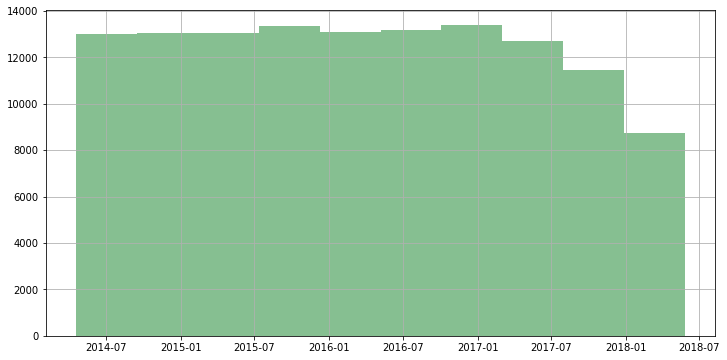

In [5]:
df.date.hist(figsize=(12,6),color='#86bf91',)


## Category Distribution

### Number of categories

In [6]:
len(set(df['category'].values))

31

### Category by count

Most of the articles are related to politics. Education related articles have the lowest volume.

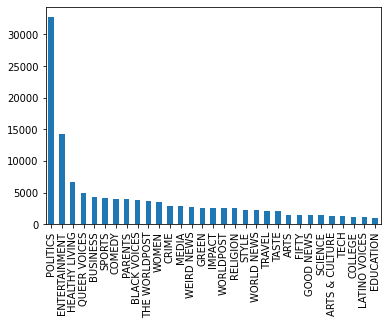

In [7]:
df['category'].value_counts().plot(kind='bar')

## Texts for Classification

These are some of the fields we can use for the classification task. We create 3 different versions.

In [8]:
import re

def tokenize_url(url:str):   
    url=url.replace("https://www.huffingtonpost.com/entry/","")
    url=re.sub("(\W|_)+"," ",url)
    return url

df['tokenized_url']=df['link'].apply(lambda x:tokenize_url(x))

#just the description
df['text_desc'] = df['short_description']

#description + headline
df['text_desc_headline'] = df['short_description'] + ' '+ df['headline']

#description + headline + tokenized url
df['text_desc_headline_url'] = df['short_description'] + ' '+ df['headline']+" " + df['tokenized_url']


In [9]:
def _reciprocal_rank(true_labels: list, machine_preds: list):
    """Compute the reciprocal rank at cutoff k"""
    
    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_preds) if r in true_labels]

    rr = 0
    if len(tp_pos_list) > 0:
        # for RR we need position of first correct item
        first_pos_list = tp_pos_list[0]
        
        # rr = 1/rank
        rr = 1 / float(first_pos_list)

    return rr

def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    rr_total = 0
    
    for item in items:   
        rr_at_k = _reciprocal_rank(item[0],item[1])
        rr_total = rr_total + rr_at_k
        mrr = rr_total / 1/float(len(items))

    return mrr

def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""
    
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list
             
def compute_accuracy(eval_items:list):
    correct=0
    total=0
    
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])
        
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break
    
    
    accuracy=correct/float(len(eval_items))
    return accuracy


In [10]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import numpy as np
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
    logging.info("Extracting features and creating vocabulary...")
    
    if "binary" in type:
        
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif "counts" in type:
        
        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

def get_top_k_predictions(model,X_test,k):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)

    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]
    
    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    
    preds=[ item[::-1] for item in preds]
    
    return preds
   
    
def train_model(df,field="text_desc",feature_rep="binary",top_k=3):
    
    logging.info("Starting model training...")
    
    # GET A TRAIN TEST SPLIT (set seed for consistent results)
    training_data, testing_data = train_test_split(df,random_state = 2000,)

    # GET LABELS
    Y_train=training_data['category'].values
    Y_test=testing_data['category'].values
     
    # GET FEATURES
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)

    # INIT LOGISTIC REGRESSION CLASSIFIER
    logging.info("Training a Logistic Regression Model...")
    scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
    model=scikit_log_reg.fit(X_train,Y_train)

    # GET TOP K PREDICTIONS
    preds=get_top_k_predictions(model,X_test,top_k)
    
    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items=collect_preds(Y_test,preds)
    
    # GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    mrr_at_k=compute_mrr_at_k(eval_items)
    
    logging.info("Done training and evaluation.")
    
    return model,feature_transformer,accuracy,mrr_at_k


## Train a Single Model

### Model  - 1  (binary features with description only)

In [11]:
field='text_desc'
feature_rep='binary'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2020-08-05 14:26:41,804 : INFO : Starting model training...
2020-08-05 14:26:41,975 : INFO : Extracting features and creating vocabulary...
2020-08-05 14:26:45,834 : INFO : Training a Logistic Regression Model...


[LibLinear]

KeyboardInterrupt: 

### Model - 2 (tfidf features with description only)

In [ ]:
field='text_desc'
feature_rep='tfidf'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

### Model - 3 (tfidf features with description, headline, url)

In [ ]:
field='text_desc_headline_url'
feature_rep='tfidf'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

## Check Predictions on Unseen Articles from CNN (not HuffPost our training data)

In [ ]:
# https://www.cnn.com/2019/07/19/politics/george-nader-child-porn-sex-charges/index.html
test_features=transformer.transform(["George Aref Nader, who was a key witness in special counsel Robert Mueller's Russia investigation, faces new charges of transporting a minor with intent to engage in criminal sexual activity and child pornography"])
get_top_k_predictions(model,test_features,2)

In [ ]:
# https://www.cnn.com/2019/07/18/entertainment/khloe-kardashian-true-thompson-video-trnd/index.html
test_features=transformer.transform(["True Thompson makes an adorable cameo in Khloe Kardashian's new makeup tutorial video"])
model.predict(test_features)
get_top_k_predictions(model,test_features,2)

In [ ]:
# https://www.cnn.com/2019/07/12/entertainment/heidi-klum-tom-kaulitz/
test_features=transformer.transform(["Heidi Klum is apparently the latest celeb to get married and not tell us"])
get_top_k_predictions(model,test_features,2)

In [ ]:
# https://www.cnn.com/2019/07/19/investing/dow-stock-market-today/index.html
test_features=transformer.transform(["Stocks end lower as geopolitical fears rise. The Dow and US markets closed lower on Friday, as geopolitical worries overshadowed the hopes of interest rate cuts by the Federal Reserve."])
get_top_k_predictions(model,test_features,2)

In [ ]:
# https://www.cnn.com/2019/07/19/health/astronaut-exercise-iv-faint-scn/index.html
test_features=transformer.transform(["Exercise in space keeps astronauts from fainting when they return to Earth, study says. "])
get_top_k_predictions(model,test_features,2)

## Train Different Types of Models

In [ ]:
feature_reps=['binary','counts','tfidf']
fields=['text_desc','text_desc_headline','text_desc_headline_url']
top_ks=[3]

results=[]
for field in fields:
    for feature_rep in feature_reps:
        for top_k in top_ks:
            model,transformer,acc,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
            results.append([field,feature_rep,top_k,acc,mrr_at_k])

### Results of Various Models

In [ ]:
df_results=pd.DataFrame(results,columns=['text_fields','feature_representation','top_k','accuracy','mrr_at_k'])
df_results.sort_values(by=['text_fields','accuracy'],ascending=False)

## Save Model for Future Use


In [ ]:
import pickle

model_path="../models/model.pkl"
transformer_path="../models/transformer.pkl"

# we need to save both the transformer -> to encode a document and the model itself to make predictions based on the weight vectors 
pickle.dump(model,open(model_path, 'wb'))
pickle.dump(transformer,open(transformer_path,'wb'))


## Use Loaded Model

In [ ]:
loaded_model = pickle.load(open(model_path, 'rb'))
loaded_transformer = pickle.load(open(transformer_path, 'rb'))


test_features=loaded_transformer.transform(["President Trump AND THE impeachment story !!!"])
get_top_k_predictions(loaded_model,test_features,2)
